In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import pymatgen

from functions.prepare_data_and_sub import prepare_dataset, make_prediction, energy_within_threshold
from functions.strusture_analysis import decompose, find_differ_sites

from functions.prepare_data_and_sub import read_pymatgen_dict

ideal_structure = read_pymatgen_dict('ideal_structure.json')
ideal_structure_sites = ideal_structure.sites

data = prepare_dataset('data/dichalcogenides_public/')
data['decomposition'] = data.structures.apply(decompose)
data = classificate_decomposition(data)
data['representative'] = data['structures'].apply(lambda x: find_differ_sites(x.sites, ideal_structure_sites))


test = prepare_dataset('data/dichalcogenides_private/', train=False)
test['decomposition'] = test.structures.apply(decompose)
test = classificate_decomposition(test)
test['representative'] = test['structures'].apply(lambda x: find_differ_sites(x.sites, ideal_structure_sites))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBClassifier, XGBRegressor
from functions.features import distance_features

In [168]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def classificate_class_big(target, n):
    if n == 3:
        if target >= 1.07 and target <= 1.13:
            return 1
        if target >= 0.985 and target <= 1.06:
            return 2
        if target >= 0.93 and target <= 0.97:
            return 3
        if target >= 0.635 and target <= 0.675:
            return 4
        return 0
    else:
        if target >= 0.38 and target <= 0.44:
            return 1
        if target >= 0.34 and target <= 0.37:
            return 2
        if target >= 0.25 and target <= 0.32:
            return 3
        return 0

In [263]:
n = 3
class_n = data[data.class_of_decomposition == n].copy()
print(len(class_n))
class_n_test = test[test.class_of_decomposition == n].copy()

class_n['group'] = class_n['targets'].apply(lambda x: classificate_class_big(x, n))
class_n = class_n[class_n.group != 0]

class_n = distance_features(class_n)
class_n_test = distance_features(class_n_test)

for i in range(3):
    class_n['dist' + str(i+1)] = class_n[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    class_n_test['dist' + str(i+1)] = class_n_test[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)

X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['group'], test_size=0.33, random_state=42)

feature_list = ['dist1', 'dist2', 'dist3']  
n_estim_clf = 14
clf = XGBClassifier(n_estimators=n_estim_clf, random_state=0xC0FFEE)
clf.fit(X_train[feature_list], y_train)

class_n_predict_target = clf.predict(X_test[feature_list])
acc1 = sum(class_n_predict_target == y_test) / len(y_test)
print(acc1)

clf.fit(class_n[feature_list], class_n['group'])
class_n_test['group'] = clf.predict(class_n_test[feature_list])

X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['targets'], test_size=0.33, random_state=42)

feature_list = ['dist1', 'dist2', 'dist3', 'group']
n_estim_reg = 14
reg = XGBRegressor(n_estimators=n_estim_reg, random_state=0xC0FFEE)

reg.fit(X_train[feature_list], y_train)

class_n_predict_target = reg.predict(X_test[feature_list])
acc2 = energy_within_threshold(class_n_predict_target, y_test)
print(acc2)
best_val = [0.12908662, 0.23559151, 0.24031008, 0.1223458,  0.12335693, 0.1280755 ]
print(best_val[n], best_val[n] * acc1 * acc2)

# reg.fit(class_n[feature_list], class_n['targets'])
# class_n_predict_target = reg.predict(class_n_test[feature_list])
# prediction = pd.read_csv('submission.csv', index_col=0)
# prediction.loc[~(test.class_of_decomposition == n), 'predictions'] = -1
# prediction.loc[(test.class_of_decomposition == n), 'predictions'] = class_n_predict_target

# prediction.to_csv(f'submissions/class{n}_clf{n_estim_clf}_reg_{n_estim_reg}.csv', index_label='id')

380
[14:35:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9444444444444444
[14:35:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9523809523809523
0.1223458 0.11004648677248677


377
2 0.8842975206611571


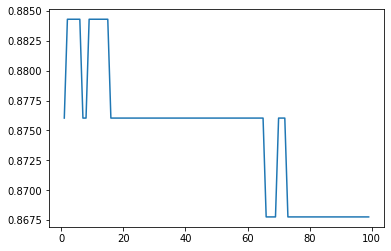

15 1.0


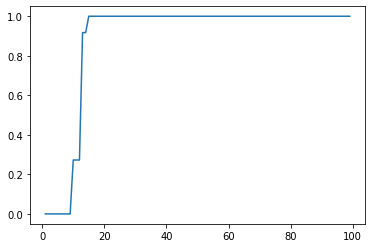

In [313]:
n = 4
class_n = data[data.class_of_decomposition == n].copy()
print(len(class_n))

class_n['group'] = class_n[['targets', 'class_of_decomposition']].apply(lambda row: classificate_class_big(row['targets'], row['class_of_decomposition']), axis=1)
class_n = class_n[class_n.group != 0]

class_n = distance_features(class_n)

for i in range(3):
    class_n['dist' + str(i+1)] = class_n[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)

X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['group'], test_size=0.33, random_state=42)

clf_results = []
n_estim_clf_list = np.arange(1, 100)
feature_list = ['dist1', 'dist2', 'dist3']  
for n_estim_clf in n_estim_clf_list:
    clf = XGBClassifier(n_estimators=n_estim_clf, random_state=0xC0FFEE, eval_metric='mlogloss')
    clf.fit(X_train[feature_list], y_train)

    class_n_predict_target = clf.predict(X_test[feature_list])
    acc1 = sum(class_n_predict_target == y_test) / len(y_test)
    clf_results.append(acc1)
    
print(n_estim_clf_list[np.argmax(clf_results)], clf_results[np.argmax(clf_results)])
plt.plot(n_estim_clf_list, clf_results)
plt.show()

feature_list = ['dist1', 'dist2', 'dist3', 'group']
X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['group'], test_size=0.33, random_state=42)

reg_results = []
n_estim_reg_list = np.arange(1, 100)
for n_estim_reg in n_estim_reg_list:
    reg = XGBRegressor(n_estimators=n_estim_reg, random_state=0xC0FFEE)
    reg.fit(X_train[feature_list], y_train)

    class_n_predict_target = reg.predict(X_test[feature_list])
    acc2 = energy_within_threshold(class_n_predict_target, y_test)
    reg_results.append(acc2)
    
print(n_estim_reg_list[np.argmax(reg_results)], reg_results[np.argmax(reg_results)])
plt.plot(n_estim_reg_list, reg_results)

In [320]:
n = 4
class_n = data[data.class_of_decomposition == n].copy()
print(len(class_n))
class_n_test = test[test.class_of_decomposition == n].copy()

class_n['group'] = class_n[['targets', 'class_of_decomposition']].apply(lambda row: classificate_class_big(row['targets'], row['class_of_decomposition']), axis=1)
class_n = class_n[class_n.group != 0]

class_n = distance_features(class_n)
class_n_test = distance_features(class_n_test)

for i in range(3):
    class_n['dist' + str(i+1)] = class_n[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    class_n_test['dist' + str(i+1)] = class_n_test[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)

    
########### CLASSIFICATION
X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['group'], test_size=0.33, random_state=42)

feature_list = ['dist1', 'dist2', 'dist3']  
n_estim_clf = 10
clf = XGBClassifier(n_estimators=n_estim_clf, random_state=0xC0FFEE)
clf.fit(X_train[feature_list], y_train)

class_n_predict_target = clf.predict(X_test[feature_list])
acc1 = sum(class_n_predict_target == y_test) / len(y_test)
print(acc1)

clf.fit(class_n[feature_list], class_n['group'])
class_n_test['group'] = clf.predict(class_n_test[feature_list])

########### REGRESSION
X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['targets'], test_size=0.33, random_state=42)

feature_list = ['dist1', 'dist2', 'dist3', 'group']
n_estim_reg = 15
reg = XGBRegressor(n_estimators=n_estim_reg, random_state=0xC0FFEE)

reg.fit(X_train[feature_list], y_train)
class_n_predict_target = reg.predict(X_test[feature_list])
acc2 = energy_within_threshold(class_n_predict_target, y_test)
print(acc2)
best_val = [0.12908662, 0.23559151, 0.24031008, 0.1223458,  0.12335693, 0.1280755 ]
print(best_val[n], best_val[n] * acc1 * acc2)

reg.fit(class_n[feature_list], class_n['targets'])
class_n_predict_target = reg.predict(class_n_test[feature_list])

########### MAKE SUBMISSION
prediction = pd.read_csv('submission.csv', index_col=0)
prediction['predictions'] = -1
prediction.loc[test.class_of_decomposition == n, 'predictions'] = class_n_predict_target

prediction.to_csv(f'submissions/class{n}_clf{n_estim_clf}_reg_{n_estim_reg}.csv', index_label='id')

377
[16:13:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8842975206611571
[16:13:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9586776859504132
0.12335693 0.10457661465473671


363
12 0.7565217391304347


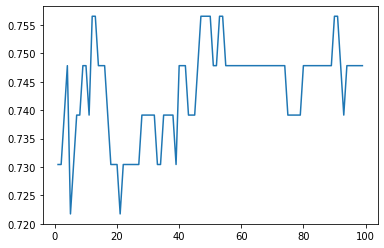

14 1.0


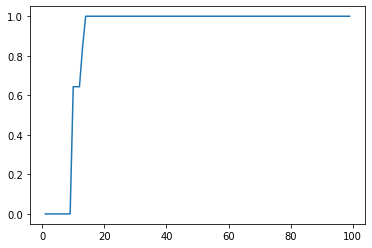

In [310]:
n = 5
class_n = data[data.class_of_decomposition == n].copy()
print(len(class_n))

class_n['group'] = class_n[['targets', 'class_of_decomposition']].apply(lambda row: classificate_class_big(row['targets'], row['class_of_decomposition']), axis=1)
class_n = class_n[class_n.group != 0]

class_n = distance_features(class_n)

for i in range(3):
    class_n['dist' + str(i+1)] = class_n[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)

X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['group'], test_size=0.33, random_state=42)

clf_results = []
n_estim_clf_list = np.arange(1, 100)
feature_list = ['dist1', 'dist2', 'dist3']  
for n_estim_clf in n_estim_clf_list:
    clf = XGBClassifier(n_estimators=n_estim_clf, random_state=0xC0FFEE, eval_metric='mlogloss')
    clf.fit(X_train[feature_list], y_train)

    class_n_predict_target = clf.predict(X_test[feature_list])
    acc1 = sum(class_n_predict_target == y_test) / len(y_test)
    clf_results.append(acc1)
    
print(n_estim_clf_list[np.argmax(clf_results)], clf_results[np.argmax(clf_results)])
plt.plot(n_estim_clf_list, clf_results)
plt.show()

feature_list = ['dist1', 'dist2', 'dist3', 'group']
X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['group'], test_size=0.33, random_state=42)

reg_results = []
n_estim_reg_list = np.arange(1, 100)
for n_estim_reg in n_estim_reg_list:
    reg = XGBRegressor(n_estimators=n_estim_reg, random_state=0xC0FFEE)
    reg.fit(X_train[feature_list], y_train)

    class_n_predict_target = reg.predict(X_test[feature_list])
    acc2 = energy_within_threshold(class_n_predict_target, y_test)
    reg_results.append(acc2)
    
print(n_estim_reg_list[np.argmax(reg_results)], reg_results[np.argmax(reg_results)])
plt.plot(n_estim_reg_list, reg_results)

In [322]:
n = 5
class_n = data[data.class_of_decomposition == n].copy()
print(len(class_n))
class_n_test = test[test.class_of_decomposition == n].copy()

class_n['group'] = class_n[['targets', 'class_of_decomposition']].apply(lambda row: classificate_class_big(row['targets'], row['class_of_decomposition']), axis=1)
class_n = class_n[class_n.group != 0]

class_n = distance_features(class_n)
class_n_test = distance_features(class_n_test)

for i in range(3):
    class_n['dist' + str(i+1)] = class_n[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    class_n_test['dist' + str(i+1)] = class_n_test[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)

    
########### CLASSIFICATION
X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['group'], test_size=0.33, random_state=42)

feature_list = ['dist1', 'dist2', 'dist3']  
n_estim_clf = 12
clf = XGBClassifier(n_estimators=n_estim_clf, random_state=0xC0FFEE)
clf.fit(X_train[feature_list], y_train)

class_n_predict_target = clf.predict(X_test[feature_list])
acc1 = sum(class_n_predict_target == y_test) / len(y_test)
print(acc1)

clf.fit(class_n[feature_list], class_n['group'])
class_n_test['group'] = clf.predict(class_n_test[feature_list])

########### REGRESSION
X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['targets'], test_size=0.33, random_state=42)

feature_list = ['dist1', 'dist2', 'dist3', 'group']
n_estim_reg = 14
reg = XGBRegressor(n_estimators=n_estim_reg, random_state=0xC0FFEE)

reg.fit(X_train[feature_list], y_train)
class_n_predict_target = reg.predict(X_test[feature_list])
acc2 = energy_within_threshold(class_n_predict_target, y_test)
print(acc2)
best_val = [0.12908662, 0.23559151, 0.24031008, 0.1223458,  0.12335693, 0.1280755 ]
print(best_val[n], best_val[n] * acc1 * acc2)

reg.fit(class_n[feature_list], class_n['targets'])
class_n_predict_target = reg.predict(class_n_test[feature_list])

########### MAKE SUBMISSION
prediction = pd.read_csv('submission.csv', index_col=0)
prediction['predictions'] = -1
prediction.loc[test.class_of_decomposition == n, 'predictions'] = class_n_predict_target

prediction.to_csv(f'submissions/class{n}_clf{n_estim_clf}_reg_{n_estim_reg}.csv', index_label='id')

363
[16:14:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7565217391304347
[16:14:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9043478260869565
0.1280755 0.08762397913043478


1065
5 0.7360703812316716


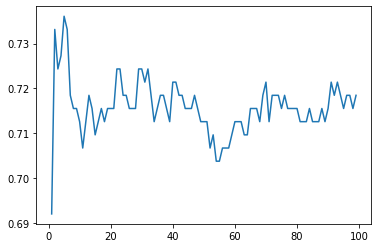

14 1.0


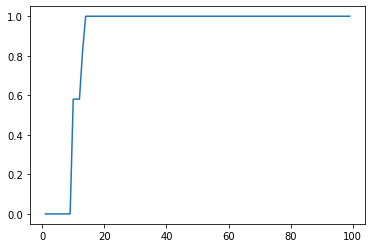

In [323]:
n = 25
class_n = data[(data.class_of_decomposition == 2) | (data.class_of_decomposition == 5)].copy()
print(len(class_n))

class_n['group'] = class_n[['targets', 'class_of_decomposition']].apply(lambda row: classificate_class_big(row['targets'], row['class_of_decomposition']), axis=1)
class_n = class_n[class_n.group != 0]

class_n = distance_features(class_n)

for i in range(3):
    class_n['dist' + str(i+1)] = class_n[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)

X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['group'], test_size=0.33, random_state=42)

clf_results = []
n_estim_clf_list = np.arange(1, 100)
feature_list = ['dist1', 'dist2', 'dist3']  
for n_estim_clf in n_estim_clf_list:
    clf = XGBClassifier(n_estimators=n_estim_clf, random_state=0xC0FFEE, eval_metric='mlogloss')
    clf.fit(X_train[feature_list], y_train)

    class_n_predict_target = clf.predict(X_test[feature_list])
    acc1 = sum(class_n_predict_target == y_test) / len(y_test)
    clf_results.append(acc1)
    
print(n_estim_clf_list[np.argmax(clf_results)], clf_results[np.argmax(clf_results)])
plt.plot(n_estim_clf_list, clf_results)
plt.show()

feature_list = ['dist1', 'dist2', 'dist3', 'group']
X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['group'], test_size=0.33, random_state=42)

reg_results = []
n_estim_reg_list = np.arange(1, 100)
for n_estim_reg in n_estim_reg_list:
    reg = XGBRegressor(n_estimators=n_estim_reg, random_state=0xC0FFEE)
    reg.fit(X_train[feature_list], y_train)

    class_n_predict_target = reg.predict(X_test[feature_list])
    acc2 = energy_within_threshold(class_n_predict_target, y_test)
    reg_results.append(acc2)
    
print(n_estim_reg_list[np.argmax(reg_results)], reg_results[np.argmax(reg_results)])
plt.plot(n_estim_reg_list, reg_results)

In [326]:
n = 25
class_n = data[(data.class_of_decomposition == 2) | (data.class_of_decomposition == 5)].copy()
print(len(class_n))
class_n_test = test[(test.class_of_decomposition == 2) | (test.class_of_decomposition == 5)].copy()

class_n['group'] = class_n[['targets', 'class_of_decomposition']].apply(lambda row: classificate_class_big(row['targets'], row['class_of_decomposition']), axis=1)
class_n = class_n[class_n.group != 0]

class_n = distance_features(class_n)
class_n_test = distance_features(class_n_test)

for i in range(3):
    class_n['dist' + str(i+1)] = class_n[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    class_n_test['dist' + str(i+1)] = class_n_test[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)

    
########### CLASSIFICATION
X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['group'], test_size=0.33, random_state=42)

feature_list = ['dist1', 'dist2', 'dist3']  
n_estim_clf = 5
clf = XGBClassifier(n_estimators=n_estim_clf, random_state=0xC0FFEE)
clf.fit(X_train[feature_list], y_train)

class_n_predict_target = clf.predict(X_test[feature_list])
acc1 = sum(class_n_predict_target == y_test) / len(y_test)
print(acc1)

clf.fit(class_n[feature_list], class_n['group'])
class_n_test['group'] = clf.predict(class_n_test[feature_list])

########### REGRESSION
X_train, X_test, y_train, y_test = train_test_split(class_n, class_n['targets'], test_size=0.33, random_state=42)

feature_list = ['dist1', 'dist2', 'dist3', 'group']
n_estim_reg = 14
reg = XGBRegressor(n_estimators=n_estim_reg, random_state=0xC0FFEE)

reg.fit(X_train[feature_list], y_train)
class_n_predict_target = reg.predict(X_test[feature_list])
acc2 = energy_within_threshold(class_n_predict_target, y_test)
print(acc2)
best_val = [0.12908662, 0.23559151, 0.24031008, 0.1223458,  0.12335693, 0.1280755 ]
print(best_val[2] + best_val[5], (best_val[2] + best_val[5]) * acc1 * acc2)

reg.fit(class_n[feature_list], class_n['targets'])
class_n_predict_target = reg.predict(class_n_test[feature_list])

########### MAKE SUBMISSION
prediction = pd.read_csv('submission.csv', index_col=0)
prediction['predictions'] = -1
prediction.loc[(test.class_of_decomposition == 2) | (test.class_of_decomposition == 5), 'predictions'] = class_n_predict_target

prediction.to_csv(f'submissions/class{n}_clf{n_estim_clf}_reg_{n_estim_reg}.csv', index_label='id')

1065
[16:44:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7360703812316716
[16:44:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9237536656891495
0.36838558 0.25048293257453924
